In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import pickle
from pprint import pprint as pp
from tqdm import tqdm
import itertools
# BASE_PATH = '/content/drive/MyDrive/Generative_ML/current_data/' #@param {type:"string"}
BASE_PATH = '/Users/morgunov/batista/Summer/pipeline/'

PRETRAINING_PATH = BASE_PATH + '1. Pretraining/'
GENERATION_PATH = BASE_PATH + '2. Generation/'
SAMPLING_PATH = BASE_PATH + '3. Sampling/'
DIFFDOCK_PATH = BASE_PATH + '4. DiffDock/'
SCORING_PATH = BASE_PATH + '5. Scoring/'
AL_PATH = BASE_PATH + '6. ActiveLearning/'


# Dataset statistics

## Convert each dictionary to a dataframe

In [ ]:
def split_the_dictionary(fname):
    with open(PICKLES+f'{fname}.pkl', 'rb') as f:
        smiles_to_descriptors = pickle.load(f)
    smiles = list(smiles_to_descriptors.keys())
    half_index = int(len(smiles)//2)
    pt1 = {}
    pt2 = {}
    for i, smile in enumerate(smiles):
        if i < half_index:
            pt1[smile] = smiles_to_descriptors[smile]
        else:
            pt2[smile] = smiles_to_descriptors[smile]
    print(len(pt1), len(pt2), len(pt1)+len(pt2), len(smiles_to_descriptors))
    pickle.dump(pt1, open(PICKLES + f'{fname}_subpt1.pkl', 'wb'))
    pickle.dump(pt2, open(PICKLES + f'{fname}_subpt2.pkl', 'wb'))

In [ ]:
split_the_dictionary('smile_to_descriptors_pt1')

In [ ]:
def pickle_to_csv(fname):
    with open(PICKLES+f'{fname}.pkl', 'rb') as f:
        smiles_to_descriptors = pickle.load(f)
    keyToData = {}
    keys = pickle.load(open(PICKLES + 'descriptors_list.pkl', 'rb'))
    pbar = tqdm(smiles_to_descriptors.items(), total=len(smiles_to_descriptors), desc=fname)
    for smile, descriptors in pbar:
        keyToData.setdefault('smile', []).append(smile)
        for key in keys:
            keyToData.setdefault(key, []).append(descriptors[key])
    df = pd.DataFrame(keyToData)
    df.to_pickle(PICKLES + '_'.join(fname.split('_')[2:]) + '.pkl')
    return df


In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt1_subpt1') # done

In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt1_subpt2') # done

In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt2_subpt1') # done

In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt2_subpt2')

In [ ]:
df = pickle_to_csv('smile_to_descriptors_pt3') # done

## Combine dataframes

In [ ]:
pt1_sbpt1 = pd.read_pickle(PICKLES + 'descriptors_pt1_subpt1.pkl')
pt1_sbpt2 = pd.read_pickle(PICKLES + 'descriptors_pt1_subpt2.pkl')
pt2_sbpt1 = pd.read_pickle(PICKLES + 'descriptors_pt2_subpt1.pkl')
pt2_sbpt2 = pd.read_pickle(PICKLES + 'descriptors_pt2_subpt2.pkl')
pt3 = pd.read_pickle(PICKLES + 'descriptors_pt3.pkl')
pt1_sbpt1.shape, pt1_sbpt2.shape, pt2_sbpt1.shape, pt2_sbpt2.shape, pt3.shape

In [ ]:
merged_df = pd.concat([pt1_sbpt1, pt1_sbpt2, pt2_sbpt1, pt2_sbpt2, pt3])
merged_df.shape
merged_df.to_pickle(PICKLES + 'descriptors_combined.pkl')

In [ ]:
descriptors_wsmiles = pd.read_pickle(PICKLES + 'descriptors_combined.pkl')
train_df = pd.read_csv(BASE_PATH + 'raw_data/processed_train.csv')
val_df = pd.read_csv(BASE_PATH + 'raw_data/processed_val.csv')
# Create boolean series for whether 'smile' column is in each dataframe
is_in_train_df = descriptors_wsmiles['smile'].isin(train_df['smiles'])
is_in_val_df = descriptors_wsmiles['smile'].isin(val_df['smiles'])

# Combine the two series with logical or (|)
is_in_either_df = is_in_train_df | is_in_val_df

# Select only rows where 'smile' column is in either dataframe
descriptors_wsmiles_excluded = descriptors_wsmiles[is_in_either_df]

descriptors_wsmiles_excluded.to_pickle(PICKLES + 'descriptors_combined_processed.pkl')

val = 285448 + 1
train = 5423523 + 1
total = val + train
print(total, descriptors_wsmiles.shape, descriptors_wsmiles_excluded.shape)
# 5708973 (5770637, 210) (5708842, 210) apparently more invalid smiles?

In [ ]:
descriptors_wsmiles = pd.read_pickle(PICKLES + 'descriptors_combined.pkl')
print(descriptors_wsmiles.shape)
train_df = pd.read_csv(BASE_PATH + 'raw_data/moses_and_binding_no_rare_tokens_train.csv.gz', compression='gzip')
test_df = pd.read_csv(BASE_PATH + 'raw_data/moses_and_binding_no_rare_tokens_test.csv.gz', compression='gzip')
# Create boolean series for whether 'smile' column is in each dataframe
is_in_train_df = descriptors_wsmiles['smile'].isin(train_df['smiles'])
is_in_test_df = descriptors_wsmiles['smile'].isin(test_df['smiles'])

# Combine the two series with logical or (|)
is_in_either_df = is_in_train_df | is_in_test_df

# Select only rows where 'smile' column is in either dataframe
descriptors_wsmiles_excluded = descriptors_wsmiles[is_in_either_df]
print(descriptors_wsmiles_excluded.shape)
descriptors_wsmiles_excluded.to_pickle(PICKLES + 'descriptors_moses+bindingdb.pkl')

val = 285448 + 1
train = 5423523 + 1
total = val + train
# print(total, descriptors_wsmiles.shape, descriptors_wsmiles_excluded.shape)
# 5708973 (5770637, 210) (5708842, 210) apparently more invalid smiles?

# PCA Analysis

## Definitions

In [2]:
def fit_pca(dataframe, n=3, sigma=None, whiten=False):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataframe)
    if sigma is not None:
        scaled_data = scaled_data[(scaled_data <= sigma).all(axis=1)]
    pca = PCA(n_components=n, whiten=whiten)
    pca.fit(scaled_data)
    return scaler, pca

def pca_transform(pca, dataframe, n):
    assert pca.n_components_ >= n, f"PCA was fitted on {pca.n_components_} components, but {n} were requested."
    transformed = pca.transform(dataframe)
    return [transformed[:,i] for i in range(n)]

def create_scatter_trace(x, y, color, name):
    return go.Scatter(x=x, y=y, mode='markers', name=name,
                      marker=dict(size=5, color=color, showscale=True if isinstance(color, (list, np.ndarray)) else False, colorscale='Viridis', opacity=0.5)
            )

def plot_pca(datapoints, yscale=1.05):
    fig = go.Figure()
    minX, minY, maxX, maxY = float('inf'), float('inf'), float('-inf'), float('-inf')
    traces = []
    for xarr, yarr, color, label in datapoints:
        minX = min(minX, min(xarr))
        minY = min(minY, min(yarr))
        maxX = max(maxX, max(xarr))
        maxY = max(maxY, max(yarr))
        traces.append(create_scatter_trace(xarr, yarr, color, label))

    for trace in traces:
        fig.add_trace(trace)

    fig.update_layout(
        xaxis=dict(title='PCA Component 1', autorange=False, range=[yscale*minX,  yscale*maxX]),
        yaxis=dict(title='PCA Component 2', autorange=False, range=[yscale*minY, yscale*maxY]),
    )
    return fig

In [3]:
def get_data_boundaries(data_list):
    combined = np.vstack(data_list) # Combine both datasets to get overall min and max values

    min_val = np.floor(np.min(combined, axis=0)/10.0) * 10 # Round to the nearest number divisible by 10
    max_val = np.ceil(np.max(combined, axis=0)/10.0) * 10
    return min_val, max_val

def discretize_data(data, boundaries, bin_size):
    # Use 2D histogram to discretize data
    bins = [np.arange(boundaries[0][i], boundaries[1][i], bin_size) for i in range(2)]
    hist_data, xedges, yedges = np.histogram2d(data[:,0], data[:,1], bins=bins)

    # Compute bin centers
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2

    return hist_data.T, xcenters, ycenters

def plot_heatmap(args_list, difference=False, bin_size=10, width=1280, height=720, all_differences=False):
    data_list, name_list = zip(*args_list)
    boundaries = get_data_boundaries(data_list)
    fig = go.Figure()

    if difference:
        if all_differences:
            traces = []
            for i, ((data_before, name_before), (data_after, name_after)) in enumerate(itertools.combinations(args_list, 2)):
                hist_before, xcenters, ycenters = discretize_data(data_before, boundaries, bin_size)
                hist_after, _, _ = discretize_data(data_after, boundaries, bin_size)
                diff = hist_after - hist_before
                label = f"|{name_after}|<br>-|{name_before}|"
                traces.append(go.Heatmap(x=xcenters, y=ycenters, z=diff, zmid=0, zmax=110, zmin=-110, colorscale='RdBu', name=label, showlegend=True, visible=True if i == 0 else 'legendonly'))
            for trace in traces:
                fig.add_trace(trace)
        else:
            assert len(data_list) == 2, f"To plot a difference, please provide only 2 data sources"
            hist_before, xcenters, ycenters = discretize_data(data_list[0], boundaries, bin_size)
            hist_after, _, _ = discretize_data(data_list[1], boundaries, bin_size)
            diff = hist_after - hist_before
            label = f"|{name_list[1]}|<br>-|{name_list[0]}|"
            fig.add_trace(go.Heatmap(x=xcenters, y=ycenters, z=diff, zmid=0, colorscale='RdBu', name=label, showlegend=True))
    else:
        traces = []
        zmax = max([discretize_data(data, boundaries, bin_size)[0].max() for data in data_list])
        zmin = min([discretize_data(data, boundaries, bin_size)[0].min() for data in data_list])
        for i, (data, name) in enumerate(args_list):
            hist, xcenters, ycenters = discretize_data(data, boundaries, bin_size)
            if 'al1 good' in name:
                mult = 1/50
            else:
                mult = 1
            traces.append(go.Heatmap(x=xcenters, y=ycenters, z=hist, name=name, zmin=zmin, zmax=mult*zmax, showlegend=True, visible=True if i == 0 else 'legendonly'))
        for trace in traces:
            fig.add_trace(trace)

    fig.update_layout(title=f'Difference in distribution: # of datapoints per bin ({bin_size=})',
                      xaxis_title='X',
                      yaxis_title='Y',
                      width=width, height=height,
                      legend=dict(x=1.2, y=1))

    return fig


In [4]:
class Graph:
    def __init__(self):
        self.title_size = 20
        self.axis_title_size = 14
        self.tick_font_size = 12
        self.text_color="#333333"
        self.background = "white"
        self.grid_color = "#e2e2e2"
        self.line_color = "#000000"
        self.font_family = 'Helvetica'
        self.width = 600
        self.height = 400
        self.title = ''
        self.xaxis_title = ''
        self.yaxis_title = ''

    def update_parameters(self, params):
        for key, val in params.items():
            setattr(self, key, val)


    def style_figure(self, figure):
        figure.update_layout({
            'margin': {'t': 50, 'b': 50, 'l': 50, 'r': 50},
            'plot_bgcolor': self.background,
            'paper_bgcolor': self.background,
            'title': {
                'text': self.title,
                'font': {
                    'size': self.title_size,
                    'color': self.text_color,
                    'family': self.font_family
                },
            },
            'height': self.height,  # Set fixed size ratio 3:4
            'width': self.width,
            'font': {
                'family': self.font_family,
                'size': self.tick_font_size,
                'color': self.text_color
            },
            'legend': {
                'font': {
                    'family': self.font_family,
                    'size': self.tick_font_size,
                    'color': self.text_color
                },
            },
        })

        # Setting the title size and color and grid for both x and y axes
        figure.update_xaxes(
            title=self.xaxis_title,
            title_font={'size': self.axis_title_size, 'color': self.text_color, 'family': self.font_family},
            tickfont={'size': self.tick_font_size, 'color': self.text_color, 'family': self.font_family},
            showgrid=True,
            gridwidth=1,
            gridcolor=self.grid_color,
            linecolor=self.line_color,  # make x axis line visible
            linewidth=2
        )

        figure.update_yaxes(
            title=self.yaxis_title,
            title_standoff=0,
            title_font={'size': self.axis_title_size, 'color': self.text_color, 'family': self.font_family},
            tickfont={'size': self.tick_font_size, 'color': self.text_color, 'family': self.font_family},
            showgrid=True,
            gridwidth=1,
            gridcolor=self.grid_color,
            linecolor=self.line_color,  # make y axis line visible
            linewidth=2
        )
        return figure

## preprocessing & fitting

In [ ]:
descriptors = pd.read_pickle(SAMPLING_PATH + 'descriptors/descriptors_moses+bindingdb.pkl')
blacklist = ['smile', 'Ipc', 'AvgIpc', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'MaxAbsPartialCharge', 'MaxPartialCharge', 'MinAbsPartialCharge', 'MinPartialCharge']
descriptors = descriptors.drop(columns=blacklist)
print(descriptors.shape)
pickle.dump(descriptors.columns.to_list(), open(PICKLES + 'descriptors_moses+bindingdb_columnlist.pkl', 'wb'))
scaler, pca = fit_pca(descriptors, n=100)
pickle.dump((scaler, pca), open(PICKLES + 'scaler_pca_moses+bingingdb.pkl', 'wb'))


## visualization

In [5]:
scaler, pca = pickle.load(open(f"{SAMPLING_PATH}pca_weights/scaler_pca_moses+bindingdb.pkl", 'rb'))
columns = pickle.load(open(f"{SAMPLING_PATH}descriptors/descriptors_moses+bindingdb_columnlist.pkl", 'rb'))
load_baseline = lambda fname: pd.read_pickle(f"{SAMPLING_PATH}descriptors/{fname}.pkl").drop_duplicates(subset='smiles')
gpt_base = load_baseline('model1_baseline_temp1.0')
gpt_sub1 = load_baseline('model1_softsub_al1_temp1.0')
gpt_div1 = load_baseline('model1_softdiv_al1_temp1.0')
gpt_sub2 = load_baseline('model1_softsub_al2_temp1.0')
gpt_div2 = load_baseline('model1_softdiv_al2_temp1.0')

pre_base = 'model1_baseline_threshold11'
pre_sub1 = 'model1_softsub_al1_threshold11'
pre_div1 = 'model1_softdiv_al1_threshold11'
pre_sub2 = 'model1_softsub_al2_threshold11'
pre_div2 = 'model1_softdiv_al2_threshold11'
l_base = lambda fname: gpt_base[gpt_base['smiles'].isin(pd.read_csv(f"{AL_PATH}training_sets/{pre_base}_{fname}.csv")['smiles'].unique())]
l_sub1 = lambda fname: gpt_sub1[gpt_sub1['smiles'].isin(pd.read_csv(f"{AL_PATH}training_sets/{pre_sub1}_{fname}.csv")['smiles'].unique())]
l_div1 = lambda fname: gpt_div1[gpt_div1['smiles'].isin(pd.read_csv(f"{AL_PATH}training_sets/{pre_div1}_{fname}.csv")['smiles'].unique())]
l_sub2 = lambda fname: gpt_sub2[gpt_sub2['smiles'].isin(pd.read_csv(f"{AL_PATH}training_sets/{pre_sub2}_{fname}.csv")['smiles'].unique())]
l_div2 = lambda fname: gpt_div2[gpt_div2['smiles'].isin(pd.read_csv(f"{AL_PATH}training_sets/{pre_div2}_{fname}.csv")['smiles'].unique())]


In [ ]:
print(l_base('linear').shape, l_base('linear_noscore').shape, l_base('softmax_divf0.25').shape, l_base('softmax_sub').shape)
print(l_sub1('softmax_sub').shape, l_sub1('softmax_sub_noscore').shape, l_div1('softmax_divf0.25').shape, l_div1('softmax_divf0.25_noscore').shape,)
print(l_sub2('softmax_sub').shape, l_sub2('softmax_sub_noscore').shape, l_div2('softmax_divf0.25').shape, l_div2('softmax_divf0.25_noscore').shape,)

In [ ]:
sample = 5_000
seed = 42
colors = {"gunmetal": "#31393C", "blue": "#4361EE", "plum": "#8E338C", "grape": "#7209B7", "red": "#D90429", "orange": "#FF7B00", "yellow": "#FFBA08", "mindaro": "#CBFF8C"}

scatter = lambda loader, fname: pca_transform(pca, scaler.transform(loader(fname)[columns]), n=2)
plot_pca(
    [
    (*pca_transform(pca, scaler.transform(gpt_base[columns].sample(n=sample, random_state=seed)), n=2), colors["gunmetal"], f'GPT baseline'),
    (*pca_transform(pca, scaler.transform(gpt_sub1[columns].sample(n=sample, random_state=seed)), n=2), colors["grape"], f'GPT Softmax Sub'),
    (*pca_transform(pca, scaler.transform(gpt_div1[columns].sample(n=sample, random_state=seed)), n=2), colors["red"], f'GPT Softmax Div0.25'),
    #(*scatter('linear'), colors["blue"], f'AL1 Linear'),
    (*scatter(l_base, 'linear_noscore'), colors["mindaro"], f'AL1 Diffusion'),
    #(*scatter(l_base, 'softmax_divf0.25'), colors["grape"], f'AL1 Softmax Div0.25'),
    #(*scatter(l_base, 'softmax_sub'), colors["red"], f'AL1 Softmax Sub'),
    ], yscale=1.5
).show()

In [ ]:
#@title
import matplotlib.pyplot as plt

var_arr = pca.explained_variance_ratio_
print(sum(var_arr))
print(sum(var_arr[:2]))
cum_varr = np.cumsum(var_arr)
plt.plot(var_arr)
plt.plot([1 for _ in range(len(var_arr))])
plt.plot(cum_varr)

In [ ]:
heat = lambda loader, fname: pca.transform(scaler.transform(loader(fname)[columns]))[:, :2]
plot_heatmap([
    (pca.transform(scaler.transform(gpt_base[columns].sample(n=5_304, random_state=seed)))[:, :2], f'GPT baseline'),
    (heat(l_base, 'linear_noscore'), f'Base Diffusion'),
    # (pca.transform(scaler.transform(al1_softmax_div_nosc[columns]))[:, :2], f'AL1 Diffusion Softmax Div0.25'),
    # (pca.transform(scaler.transform(al1_softmax_sub_nosc[columns]))[:, :2], f'AL1 Diffusion Softmax Sub'),
    (heat(l_base, 'linear'), f'AL1 Linear'),
    (heat(l_base, 'softmax_divf0.25'), f'AL1 Softmax Div0.25'),
    (heat(l_base, 'softmax_sub'), f'AL1 Softmax Sub'),
], difference=True, all_differences=True, bin_size=1.5, width=900, height=500)



In [ ]:
plot_heatmap([
    (pca.transform(scaler.transform(gpt_base[columns].sample(n=5_304, random_state=seed)))[:, :2], f'GPT baseline'),
    (pca.transform(scaler.transform(gpt_sub1[columns].sample(n=5_406, random_state=seed)))[:, :2], f'GPT Sub1'),
    (heat(l_sub1, 'softmax_sub_noscore'), f'Sub1 Diffusion'),
    (heat(l_sub1, 'softmax_sub'), f'AL2 Softmax Sub'),
], difference=True, all_differences=True, bin_size=1.5, width=900, height=500)

In [ ]:
plot_heatmap([
    (pca.transform(scaler.transform(gpt_base[columns].sample(n=5_304, random_state=seed)))[:, :2], f'GPT baseline'),
    (pca.transform(scaler.transform(gpt_div1[columns].sample(n=5_363, random_state=seed)))[:, :2], f'GPT Div1'),
    (heat(l_div1, 'softmax_divf0.25_noscore'), f'Div1 Diffusion'),
    (heat(l_div1, 'softmax_divf0.25'), f'AL2 Softmax Div'),
], difference=True, all_differences=True, bin_size=1.5, width=900, height=500)

In [ ]:
plot_heatmap([
    (pca.transform(scaler.transform(gpt_base[columns].sample(n=5_304, random_state=seed)))[:, :2], f'GPT baseline'),
    (pca.transform(scaler.transform(gpt_sub2[columns].sample(n=5_406, random_state=seed)))[:, :2], f'GPT Sub2'),
    (heat(l_sub2, 'softmax_sub_noscore'), f'Sub2 Diffusion'),
    (heat(l_sub2, 'softmax_sub'), f'AL3 Softmax Sub'),
], difference=True, all_differences=True, bin_size=1.5, width=900, height=500)

In [ ]:
l_div2

In [ ]:
plot_heatmap([
    (pca.transform(scaler.transform(gpt_base[columns].sample(n=5_304, random_state=seed)))[:, :2], f'GPT baseline'),
    (pca.transform(scaler.transform(gpt_div2[columns].sample(n=5_363, random_state=seed)))[:, :2], f'GPT Div2'),
    (heat(l_div2, 'softmax_divf0.25_noscore'), f'Div2 Diffusion'),
    (heat(l_div2, 'softmax_divf0.25'), f'AL3 Softmax Div'),
], difference=True, all_differences=True, bin_size=1.5, width=900, height=500)

# Distribution Analysis

## Definitions

In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

load_dist = lambda fname: pd.read_csv(f"{SCORING_PATH}scored_dataframes/{fname}.csv")['score'].to_numpy()

def compute_cluster_scores(fname):
    good_data = pd.read_csv(f"{SCORING_PATH}scored_dataframes/{fname}.csv")
    cluster_to_scores = {}
    for index, row in good_data.iterrows():
        cluster_to_scores.setdefault(row['cluster_id'], []).append(row['score'])
    cluster_to_score = {cluster_id: np.mean(scores) for cluster_id, scores in cluster_to_scores.items()}
    return np.array(list(cluster_to_score.values()))

#dark to light
biscale = {"blue": ("#03045e", "#023e8a"), "purple": ("#7b2cbf", "#c77dff"), "green": ("#008000", "#70e000"), "red": ("#a4133c", "#ff4d6d"), "brown": ("#6f4518", "#bc8a5f")}

def create_hist_trace(i, data, label, color, threshold, bin_step):
    # Generate KDE for data
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data), np.max(data), 200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()

    hist_vals, bin_edges = np.histogram(data, bins=range(0, int(np.max(data)) + 2, bin_step), density=True)
    hist = go.Bar(x=bin_edges[:-1], y=hist_vals, name=label, opacity=0.6, marker=dict(color=biscale[color][1]),
                  hovertemplate=[f'[{int(i)}, {int(i + bin_step)})' for i in bin_edges[:-1]])
    #nbins=30
    #hist = go.Histogram(x=data, nbinsx=nbins, name=label, histnorm='probability', opacity=0.6, marker=dict(color=biscale[color][1]))
    density_curve = go.Scatter(x=xs, y=density(xs), mode='lines', name=label + ' Density', line=dict(color=biscale[color][0]))

    above_threshold_pct = np.sum(data > threshold) / len(data) * 100
    q25, q50, q75, q90 = np.percentile(data, [25, 50, 75, 90])
    max = data.max()

    annotation = dict(
        x=0.95, y=1.0 - 0.04*i, xref='paper', yref='paper',
        text=f"{label}: % > threshold = {above_threshold_pct:.2f}, Q25 = {q25:.2f}, Q50 = {q50:.2f}, Q75 = {q75:.2f}, Q90 = {q90:.2f}, max = {max:.2f}",
        showarrow=False, font=dict(size=12))

    return [hist, density_curve], annotation

def plot_hist_density(data_list, title_spec, threshold=11, bin_step=2):
    graph = Graph()
    traces, annotations = [], []
    for i, data in enumerate(data_list):
        new_traces, annotation = create_hist_trace(i, *data, threshold, bin_step)
        traces.extend(new_traces)
        annotations.append(annotation)

    # Create figure and add traces
    fig = go.Figure(data=traces, layout=go.Layout(bargap=0.2, barmode='overlay', shapes=[
                      dict(type="line", x0=threshold, x1=threshold, y0=0, y1=1,
                           yref='paper',  # refers to the entire plot for the y-dimension
                           line=dict(color="grey", width=2, dash='longdash'))],
                      annotations=annotations))

    # Show figure
    graph.update_parameters(dict(title=f'Distribution of {title_spec} scores based on DiffDock Poses',
                                 xaxis_title='Prolif Score', yaxis_title='Rel. Frequency', width=1280, height=600))
    graph.style_figure(fig)
    fig.show()

## Individual Scores

In [ ]:
plot_hist_density([
    (load_dist('model1_baseline'), 'Baseline', 'blue'),
    #(load_dist('model1_baseline_random'), 'Baseline Random', 'red'),
    #(load_dist('model1_random_al1'), 'Random Al1', 'purple'),
    #(load_dist('model1_softdiv_al1'), 'SoftDiv Al1', 'purple'), #(load_dist('model1_softdiv_al2'), 'SoftDiv Al2', 'red'),
    (load_dist('model1_softsub_al1'), 'SoftSub Al1', "green"), #(load_dist('model1_softsub_al2'), 'SoftSub Al2', "brown")
], title_spec='ligand', bin_step=1, threshold=11)

In [ ]:
plot_hist_density([
    (compute_cluster_scores('model1_baseline'), 'Baseline', 'blue'),
    (compute_cluster_scores('model1_baseline_random'), 'Baseline Random', 'red'),
    # (compute_cluster_scores('model1_softdiv_al1'), 'SoftDiv Al1', 'purple'), (compute_cluster_scores('model1_softsub_al1'), 'SoftSub Al1', "green"),
    # (compute_cluster_scores('model1_softdiv_al2'), 'SoftDiv Al2', 'red'), (compute_cluster_scores('model1_softsub_al2'), 'SoftSub Al2', "brown")
], title_spec='cluster', bin_step=1, threshold=11)

In [ ]:
import plotly.graph_objs as go

def plot_correlation_circle(pca, features):
    pcs = pca.components_

    # Create a trace for the variable vectors
    vectors = go.Scatter(
        x=pcs[0, :],
        y=pcs[1, :],
        mode='lines+markers+text',
        text=features,
        textposition='top center',
        line=dict(color='red'),
        marker=dict(size=10, color='blue'),
        textfont=dict(size=8)
    )

    # Create a trace for the unit circle
    circle = go.Scatter(
        x=np.cos(np.linspace(0, 2*np.pi, 100)),
        y=np.sin(np.linspace(0, 2*np.pi, 100)),
        mode='lines',
        line=dict(color='blue', width=1),
        showlegend=False
    )

    layout = go.Layout(
        title = 'Correlation Circle',
        autosize=False,
        width=800,
        height=800,
        showlegend=False,
        xaxis=dict(
            title=f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)",
            range=[-1.1, 1.1],
            zeroline=False,
            showgrid=True,
            domain=[0, 1],
        ),
        yaxis=dict(
            title=f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)",
            range=[-1.1, 1.1],
            zeroline=False,
            showgrid=True,
            domain=[0, 1],
        )
    )

    fig = go.Figure(data=[vectors, circle], layout=layout)
    fig.show()

# Assuming pca is your PCA model fitted with sklearn and df is the pandas dataframe with your original data
plot_correlation_circle(pca, descriptors.columns.values)


In [ ]:
pca.explained_variance_ratio_

# t-SNE and UMAP

## Definitions

In [ ]:
from sklearn.cluster import KMeans
def _cluster_mols(mols, n_clusters, save_path, n_iter=1):
    """
        Performs K-Means clustering on a given list of molecules and saves the model to a specified file.

        This function will apply the K-Means algorithm to the input list of molecules. If n_iter is set to 1 (default), the function will perform the clustering once and return the KMeans object. If n_iter is set to more than 1, the function will perform the clustering n_iter times and return the KMeans object with the lowest inertia (i.e., the sum of squared distances of samples to their closest cluster center). The function will save the KMeans object to a file at the specified save_path using pickle.

        Parameters

            mols : array-like or sparse matrix, shape (n_samples, n_features)
            The input samples where n_samples is the number of samples and n_features is the number of features.

            n_clusters : int
            The number of clusters to form as well as the number of centroids to generate.

            save_path : str
            The path (including file name) where the resulting KMeans object should be saved.

            n_iter : int, optional (default=1)
            The number of times to perform the clustering. If greater than 1, the function will return the KMeans object with the lowest inertia.

        Returns

            kmeans : sklearn.cluster._kmeans.KMeans
            A KMeans instance trained on the input molecules. If n_iter is greater than 1, it's the best performing model (lowest inertia) from all iterations.

    """
    if n_iter == 1:
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
        pickle.dump(kmeans, open(save_path, 'wb'))
        return kmeans
    best_kmeans = None
    best_inertia = float('inf')
    for _ in range(n_iter):
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++').fit(mols)
        if kmeans.inertia_ < best_inertia:
            best_kmeans = kmeans
            best_inertia = kmeans.inertia_
    pickle.dump(best_kmeans, open(save_path, 'wb'))
    return best_kmeans


## Code

In [11]:
base_df = pd.read_csv(f"{SCORING_PATH}scored_dataframes/model1_baseline.csv")
sub1_df = pd.read_csv(f"{SCORING_PATH}scored_dataframes/model1_softsub_al1.csv")
div1_df = pd.read_csv(f"{SCORING_PATH}scored_dataframes/model1_softdiv_al1.csv")
sub2_df = pd.read_csv(f"{SCORING_PATH}scored_dataframes/model1_softsub_al2.csv")
div2_df = pd.read_csv(f"{SCORING_PATH}scored_dataframes/model1_softdiv_al2.csv")
scored_base = gpt_base[gpt_base['smiles'].isin(base_df['smiles'].unique())]
scored_sub1 = gpt_sub1[gpt_sub1['smiles'].isin(sub1_df['smiles'].unique())]
scored_div1 = gpt_div1[gpt_div1['smiles'].isin(div1_df['smiles'].unique())]
scored_sub2 = gpt_sub2[gpt_sub2['smiles'].isin(sub2_df['smiles'].unique())]
scored_div2 = gpt_div2[gpt_div2['smiles'].isin(div2_df['smiles'].unique())]
smiles, scores, descriptors = [], [], []
for df in [base_df, sub1_df, div1_df, sub2_df, div2_df]: 
    smiles.extend(df['smiles'])
    scores.extend(df['score'])
descriptors_all = pd.concat([scored_base, scored_sub1, scored_div1, scored_sub2, scored_div2])
scored_all = pd.concat([base_df, sub1_df, div1_df, sub2_df, div2_df])
print(scored_all.shape)
scored_all.head()

(5000, 5)


,Unnamed: 0.1,Unnamed: 0,smiles,cluster_id,score
0,0,0,[C]c1cc(CNC(=O)c2cc(NC(=O)c3cc(-c4cnccn4)c(Cl)...,5,7.5
1,1,1,[CH]CCOc1ccccc1NC(=O)c1csc(C)n1,2,2.0
2,2,2,COc1ccc(S(=O)(=O)N(CC(C)C)C[C@@H](O)[C@H](Cc2c...,2,23.5
3,3,3,OC1C(c2ccccc2)O[C@H](CN2CC[N+]C(CCl)(CCCCc3ccc...,2,4.0
4,4,4,[CH]C1CCN(C(=O)Oc2ccc(/C=c3\[nH]c(=O)/c(=C/c4c...,2,17.5


In [12]:
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem

def calculate_mqn_descriptors(df):
    keyToData = {}
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        smile = row['smiles']
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            continue
        keyToData.setdefault('smiles', []).append(smile)
        keyToData.setdefault('score', []).append(row['score'])
        descriptors = rdMolDescriptors.MQNs_(mol)
        assert len(descriptors) == 42, f"Expected 42 descriptors, got {len(descriptors)}"
        for i, descriptor in enumerate(descriptors):
            keyToData.setdefault(f"MQN{i}", []).append(descriptor)
    return pd.DataFrame(keyToData)

mqn_df = calculate_mqn_descriptors(scored_all)
mqn_df.head()

100%|██████████| 5000/5000 [00:01<00:00, 3585.20it/s]


,smiles,score,MQN0,MQN1,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,...,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41
0,[C]c1cc(CNC(=O)c2cc(NC(=O)c3cc(-c4cnccn4)c(Cl)...,7.5,26,0,2,0,0,0,0,2,...,0,0,2,3,0,0,0,0,0,0
1,[CH]CCOc1ccccc1NC(=O)c1csc(C)n1,2.0,14,0,0,0,0,1,0,1,...,0,0,1,1,0,0,0,0,0,0
2,COc1ccc(S(=O)(=O)N(CC(C)C)C[C@@H](O)[C@H](Cc2c...,23.5,36,0,0,0,0,1,0,2,...,0,0,1,4,0,0,0,0,2,1
3,OC1C(c2ccccc2)O[C@H](CN2CC[N+]C(CCl)(CCCCc3ccc...,4.0,27,0,1,0,0,0,0,0,...,0,0,1,2,1,0,0,0,0,0
4,[CH]C1CCN(C(=O)Oc2ccc(/C=c3\[nH]c(=O)/c(=C/c4c...,17.5,23,0,0,0,0,0,0,0,...,0,0,1,3,0,0,0,0,0,0


In [34]:
mqn_and_other = pd.merge(mqn_df, descriptors_all, on='smiles')
mqn_and_other.shape, mqn_df.shape, descriptors_all.shape
len(set(mqn_df['smiles'])),  len(set(descriptors_all['smiles']))

(4990, 4990)

0.9999999999999998
0.3863821948170182


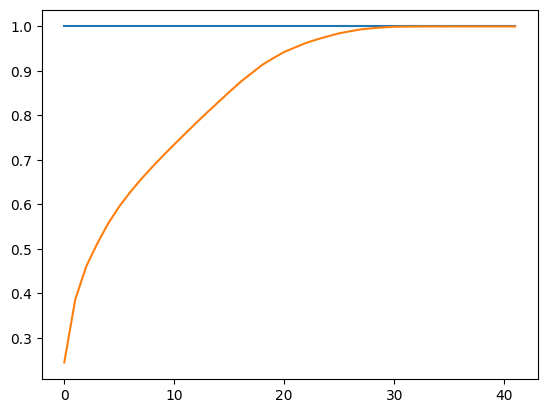

In [13]:
scaler, pca = fit_pca(mqn_df.drop(columns=['smiles', 'score']), n=42)
import matplotlib.pyplot as plt

var_arr = pca.explained_variance_ratio_
print(sum(var_arr))
print(sum(var_arr[:2]))
cum_varr = np.cumsum(var_arr)
plt.plot([1 for _ in range(len(var_arr))])
plt.plot(cum_varr)

In [14]:
scores = mqn_df['score'].to_numpy()
threshold = np.array([1 if score >= 11 else 0 for score in scores])
threshold.shape

(5000,)

In [ ]:
import yaml
with open(f"pca_study/columns/no_fr.yaml", 'r') as f:
    no_fr_cols = yaml.load(f, Loader=yaml.FullLoader)
with open(f"pca_study/columns/no_counts.yaml", 'r') as f:
    no_counts_cols = yaml.load(f, Loader=yaml.FullLoader)
with open(f"pca_study/columns/no_fr_counts.yaml", 'r') as f:
    no_fr_counts_cols = yaml.load(f, Loader=yaml.FullLoader)

In [15]:
import numpy as np
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Assume data is a numpy array of shape (n, d)
# data = np.random.rand(1000, 110)  # Uncomment this line to test with random data

def run_tsne(data, n_components=2, perplexity=30):
    tsne = TSNE(n_components=n_components, perplexity=perplexity)
    tsne_results = tsne.fit_transform(data)
    return tsne_results

def run_umap(data, n_components=2, n_neighbors=15):
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors)
    umap_results = reducer.fit_transform(data)
    return umap_results

def split_2d(data, n=2):
    return [data[:, i] for i in range(n)]

def fit_and_transform(data, n):
    scaler, pca = fit_pca(data, n=n)
    transformed = pca.transform(data)
    return transformed

/Users/morgunov/.pyenv/versions/3.11.4/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/morgunov/.pyenv/versions/3.11.4/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/morgunov/.pyenv/versions/3.11.4/lib/python3.11/site-pac

In [20]:
data_54 = fit_and_transform(mqn_df.drop(columns=['smiles', 'score']), n=42)
args = []
perplexities = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
pbar = tqdm(perplexities, total=len(perplexities))
for i in pbar:
    pbar.set_description(f'Perplexity {i}')
    args.append((*split_2d(run_tsne(data_54, perplexity=i)), threshold, f'Perplexity {i}'))
plot_pca(args, yscale=1.5).show()

/Users/morgunov/.pyenv/versions/3.11.4/lib/python3.11/site-packages/scikit_learn-1.2.2-py3.11-macosx-13.4-arm64.egg/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names

Perplexity 50: 100%|██████████| 10/10 [02:22<00:00, 14.22s/it]


In [23]:
data_54 = fit_and_transform(mqn_and_other.drop(columns=['smiles', 'score']), n=42)
scores = mqn_and_other['score'].to_numpy()
threshold = np.array([1 if score >= 11 else 0 for score in scores])
args = []
perplexities = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
pbar = tqdm(perplexities, total=len(perplexities))
for i in pbar:
    pbar.set_description(f'Perplexity {i}')
    args.append((*split_2d(run_tsne(data_54, perplexity=i)), threshold, f'Perplexity {i}'))
plot_pca(args, yscale=1.5).show()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [16]:
cols = columns
print('tsne 54')
tsne_54 = run_tsne(fit_and_transform(mqn_df.drop(columns=['smiles', 'score']), n=42))
print('umap 54')
umap_54 = run_umap(fit_and_transform(mqn_df.drop(columns=['smiles', 'score']), n=42))

tsne 54


/Users/morgunov/.pyenv/versions/3.11.4/lib/python3.11/site-packages/scikit_learn-1.2.2-py3.11-macosx-13.4-arm64.egg/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


umap 54


/Users/morgunov/.pyenv/versions/3.11.4/lib/python3.11/site-packages/scikit_learn-1.2.2-py3.11-macosx-13.4-arm64.egg/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [17]:
plot_pca(
    [
    (*split_2d(umap_54), threshold, f'Scored UMAP from 54'),
    (*split_2d(tsne_54), threshold, f'Scored t-SNE from 54'),
    ], yscale=1.5
).show()

In [ ]:
plot_pca(
    [
    (*split_2d(tsne_48_no_fr_co), threshold, f'Scored t-SNE from 48'),
    (*split_2d(tsne_91_no_fr_co), threshold, f'Scored t-SNE from 91'),
    ], yscale=1.5
).show()

In [ ]:
below = np.array(scores < 11)
above = np.array(scores >= 11)
tsne_195.shape, tsne_195[below].shape, tsne_195[above].shape, sum(below), sum(above), sum(below)+sum(above)

In [ ]:
plot_heatmap([
    (tsne_195[below], f'tSNE 195 below'),
    (tsne_195[above], f'tSNE 195 above'),
    # (umap_195, f'UMAP 195'),
], difference=False, all_differences=False, bin_size=3, width=900, height=500)

In [ ]:
import yaml
scaler, pca = pickle.load(open(f"pca_study/checkpoints/scaler_pca_valid_columns.pkl", 'rb'))
kmeans = _cluster_mols(scored_all[columns], 10, "pca_study/kmeans_10.pkl", n_iter=10)

sample = 5_000
seed = 42
colors = {"gunmetal": "#31393C", "blue": "#4361EE", "plum": "#8E338C", "grape": "#7209B7", "red": "#D90429", "orange": "#FF7B00", "yellow": "#FFBA08", "mindaro": "#CBFF8C"}

scatter = lambda loader, fname: pca_transform(pca, scaler.transform(loader(fname)[columns]), n=2)
plot_pca(
    [
    # (*pca_transform(pca, scaler.transform(gpt_base[columns].sample(n=sample, random_state=seed)), n=2), colors["gunmetal"], f'GPT baseline'),
    # (*pca_transform(pca, scaler.transform(scored_all[columns]), n=2), scores, f'Scored mols'),
    (*pca_transform(pca, scaler.transform(scored_all[columns]), n=2), kmeans.labels_, f'Clusters of scored'),
    # (*pca_transform(pca_nofr, scaler_nofr.transform(scored_all[columns_nofr]), n=2), scores, f'pca nofr'),
    # (*pca_transform(pca, scaler.transform(scored_base[columns]), n=2), scores, f'Scored base'),
    # (*pca_transform(pca, scaler.transform(scored_sub1[columns]), n=2), scores, f'Scored sub1'),
    # (*pca_transform(pca, scaler.transform(scored_div1[columns]), n=2), scores, f'Scored div1'),
    ], yscale=1.5
).show()